## 1.导入数据

本次作业主要参考PyTorch官方的教程（https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py） 和陈云编著的《深度学习框架》

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

可以直接运行下列代码下载cifar数据集,因为我已经把数据集下载下来了，所以把cifar.py中的url改为本地地址，就不需要上网站下载了。

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])#数据集加载时，默认的图片格式是 numpy，所以通过 transforms 转换成 Tensor。
                                                              #然后，再对输入图片进行标准化。

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


先用例子随便探索一下pytorch的用法吧

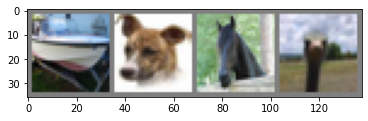

 ship   dog horse  bird


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize  还原被归一化的数据
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))    #
    plt.show()


# get some random training images
dataiter = iter(trainloader)    #可迭代的对象
images, labels = dataiter.next()  #相当于list里的取第几个，此处每次都会被打乱，所以是随机的四张图。

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

dataset 对象是一个数据集，可以按下访问，返回如（data,lebel）的数据

ship


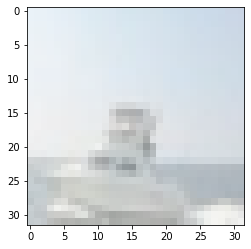

8
tensor([[[0.6706, 0.6549, 0.6549,  ..., 0.1843, 0.1843, 0.1686],
         [0.6784, 0.6627, 0.6627,  ..., 0.1922, 0.1922, 0.1843],
         [0.6941, 0.6784, 0.6706,  ..., 0.2000, 0.2000, 0.1843],
         ...,
         [0.1373, 0.0667, 0.1216,  ..., 0.6941, 0.5373, 0.4353],
         [0.0902, 0.0118, 0.0118,  ..., 0.7804, 0.7490, 0.6392],
         [0.0745, 0.1216, 0.0667,  ..., 0.6392, 0.7020, 0.7882]],

        [[0.7961, 0.7804, 0.7804,  ..., 0.3647, 0.3647, 0.3490],
         [0.7961, 0.7804, 0.7804,  ..., 0.3725, 0.3725, 0.3647],
         [0.7961, 0.7804, 0.7804,  ..., 0.3804, 0.3804, 0.3647],
         ...,
         [0.2471, 0.1608, 0.1922,  ..., 0.7020, 0.5451, 0.4353],
         [0.2000, 0.1137, 0.0902,  ..., 0.7882, 0.7569, 0.6392],
         [0.1922, 0.2157, 0.1373,  ..., 0.6392, 0.7020, 0.7882]],

        [[0.8980, 0.8824, 0.8824,  ..., 0.6157, 0.6157, 0.6000],
         [0.8902, 0.8745, 0.8745,  ..., 0.6235, 0.6235, 0.6078],
         [0.8745, 0.8588, 0.8588,  ..., 0.6157, 0.6157, 

In [4]:
(data,label)=trainset[100]
print(classes[label])
imshow((data+1)/2)
print(label)
print(data)

DataLoader本质上就是一个iterable（跟python的内置类型list等一样），并利用多进程来加速batch data的处理，使用yield来使用有限的内存。

## 2. 利用logistic方法进行图像识别

参考自github上用户praveenr2998的CIFAR-10 USING LOGISTIC REGRESSION
https://github.com/praveenr2998/CIFAR10-Pytorch/blob/master/CIFAR10_logistic_regression.ipynb

In [8]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
#划分训练集和验证集
train_ds, val_ds = random_split(trainset, [40000,10000])
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
len(train_ds), len(val_ds)

(40000, 10000)

In [9]:
#定义检验准确度的函数
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [10]:
input_size = 3*32*32  #Tensor的形状
num_classes = 10    #类的数量

In [12]:
#定义训练模型
import torch.nn as nn  #定义网络时，需要继承nn.Module,并实现它的forward方法，把网络中具有可学习参数的层放在构造函数中。
import torch.nn.functional as F  #内置多重函数，参考官方文档https://pytorch-cn.readthedocs.io/zh/latest/package_references/functional/
class CifarModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)   #全连接层
        
    def forward(self, xb):                    #定义了forward函数，backward函数会被自动实现（利用Autograd）
        xb = xb.reshape(-1, input_size)         #该函数变量进变量出。
        out = self.linear(xb)                     # Here self(images) passes the images to forward function...this is a method of calling a fuction within class without the use of object facilitated by pytorch..
        return out
    
    def training_step(self, batch):             #训练步骤
        images, labels = batch 
        out = self(images)                  # Generate predictions   生成预测值
        loss = F.cross_entropy(out, labels) # Calculate loss     计算成本
        return loss
    
    def validation_step(self, batch):         #验证
        images, labels = batch 
        out = self(images)                    # Generate predictions      生成预测值
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy        计算Accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):           #输出loss和accuracy
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = CifarModel()

In [13]:

def evaluate_model(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]         #每一次取batch小批量地进行训练，并计算loss和accu
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):       #使用模型，进行迭代，迭代次数为epochs，lr：logistic
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate_model(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [14]:
# Testing model before updation of weights and biases 不反向传播之前先测试一下该模型
result0 = evaluate_model(model, val_loader)
result0

{'val_loss': 2.371899127960205, 'val_acc': 0.0816851258277893}

In [15]:
#开始进行反向传播，训练模型
history1 = fit(20, 0.001, model, train_loader, val_loader) #fit(迭代次数, lr, 模型, train_loader, val_loader, 优化算法：SGD随机梯度下降)

Epoch [0], val_loss: 1.9894, val_acc: 0.3166
Epoch [1], val_loss: 1.9193, val_acc: 0.3438
Epoch [2], val_loss: 1.8836, val_acc: 0.3557
Epoch [3], val_loss: 1.8610, val_acc: 0.3635
Epoch [4], val_loss: 1.8451, val_acc: 0.3688
Epoch [5], val_loss: 1.8332, val_acc: 0.3734
Epoch [6], val_loss: 1.8236, val_acc: 0.3752
Epoch [7], val_loss: 1.8160, val_acc: 0.3804
Epoch [8], val_loss: 1.8088, val_acc: 0.3832
Epoch [9], val_loss: 1.8028, val_acc: 0.3870
Epoch [10], val_loss: 1.7981, val_acc: 0.3864
Epoch [11], val_loss: 1.7931, val_acc: 0.3890
Epoch [12], val_loss: 1.7894, val_acc: 0.3896
Epoch [13], val_loss: 1.7859, val_acc: 0.3911
Epoch [14], val_loss: 1.7824, val_acc: 0.3925
Epoch [15], val_loss: 1.7788, val_acc: 0.3972
Epoch [16], val_loss: 1.7757, val_acc: 0.3959
Epoch [17], val_loss: 1.7733, val_acc: 0.3996
Epoch [18], val_loss: 1.7707, val_acc: 0.3991
Epoch [19], val_loss: 1.7687, val_acc: 0.4001
